# Exploratory Data Analysis of Airbnb listings in Barcelona #

In the present work, I will try to analyze and obtain useful information about different behaviors and trends from the data obtained from an Airbnb 'dataframe' corresponding to the city of Barcelona. As reflected in this notebook, the work has not been completely smooth or perfect, but rather I have explored different options for visualizing the data. Additionally, in the initial phase, it has been challenging to choose which data to delete, which to consider, and how, considering the influence these decisions could have on the final results.

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data cleaning and preprocessing ##

In [2]:
path = '.\listings.csv'
df = pd.read_csv(path, index_col='id')

In [3]:
airbnb_data = df.copy()

In [4]:
airbnb_data.drop('license', axis=1, inplace=True)
airbnb_data.dropna(axis = 0,how='any', subset=['last_review', 'reviews_per_month'],
                    inplace=True)

In [5]:
airbnb_data['is_replaced_na'] = airbnb_data.price.isna()

price_median = airbnb_data.price.median()
airbnb_data['price'].fillna(price_median, inplace = True)
price_median

90.0

In [6]:
# Calculate the first and third quartiles
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Remove outliers
# airbnb_data = airbnb_data[(airbnb_data['price'] > lower_bound) &
#                            (airbnb_data['price'] < upper_bound)]
airbnb_data['is_outlier_price'] = airbnb_data.price > upper_bound
airbnb_data.loc[airbnb_data.price > upper_bound, 'price'] = upper_bound

print(upper_bound)

250.0


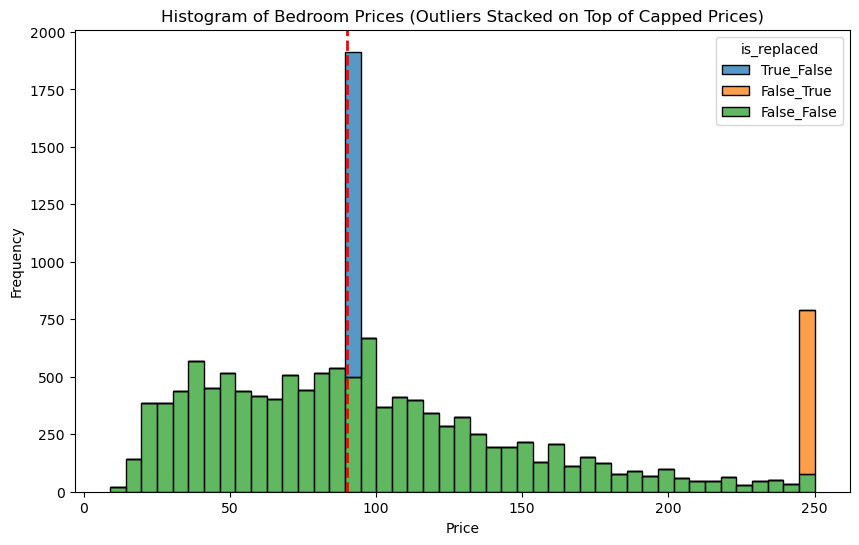

In [7]:

import seaborn as sns
import matplotlib.pyplot as plt

# Plot the histogram of capped prices and outliers separately using Seaborn
plt.figure(figsize=(10, 6))
airbnb_data['is_replaced'] = airbnb_data.is_replaced_na.astype(str) + '_' + airbnb_data.is_outlier_price.astype(str)
hue_order = ['True_False', 'False_True','False_False']
sns.histplot(data=airbnb_data, x="price", multiple='stack', 
             hue='is_replaced', hue_order=hue_order)
plt.axvline(airbnb_data.price.median() , color='red', linestyle='dashed', linewidth=2)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram of Bedroom Prices (Outliers Stacked on Top of Capped Prices)')
plt.show()

Regarding data preprocessing:

I had to decide whether to discard rows with 'NaNs' in the price column, and in that case, consider that I would lose all the information from those rows. One possibility to address this issue is to consider storing the 'NaNs' in the median so that I could still have the information from the rows. This could have been carried out, but we observe in this stacked histogram that there is a disproportionate accumulation of values, or, at least, in my opinion, excessive. Therefore, finally, I have decided to do away with these values.

Another issue with this dataframe is the number of outliers and the exorbitant prices they reflect. For instance, we encounter a price exceeding 50k per night for accommodation in the Guinardó area. Not only is the price striking, but we can also affirm that it is an error when we further confirm that this neighborhood is completely outside both the affluent area ('Upper Diagonal') and the central area of Barcelona. In this histogram, I have also tried to provide a comprehensible visualization of how many values truly fall into the upper bound and which ones I have accumulated by choice at this point (meaning all outliers are concentrated in the upper bound). As we observe, we are also accumulating a large number of values, which may lead to result errors and consequently errors in the subsequent interpretation of the obtained data. Therefore, I have also decided to do away with the values corresponding to the outliers.

As I was gathering more information on Airbnb, I noticed that some owners list their rooms with extremely high prices so no one will book them, in order to avoid having to take down the listing. That could also be a plausible exaplanation for outliers.



In [8]:
#making a new copy of the original dataset
airbnb_data = df.copy()

In [9]:
airbnb_data.drop('license', axis=1, inplace=True)
airbnb_data.dropna(axis = 0,how='any', subset=['last_review', 'reviews_per_month'],
                    inplace=True)
# dropping rows w/ missing price
airbnb_data.dropna(axis = 0, subset = ['price'], inplace=True)

In [10]:
# Here I'll calculate the first and third quartiles
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)

# Calculating the interquartile range (IQR)
IQR = Q3 - Q1

# Defining lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# removing outliers
airbnb_data = airbnb_data[(airbnb_data['price'] > lower_bound) &
                           (airbnb_data['price'] < upper_bound)]


In the provided code, I use quartile-based statistics to identify and remove outliers from the 'price' column in my dataset. First, I calculate the first and third quartiles (Q1 and Q3) to determine the Interquartile Range (IQR), which captures the middle 50% of the data.

Using the IQR, I establish lower and upper bounds for outlier detection at Q1 - 1.5 * IQR and Q3 + 1.5 * IQR, respectively. Data points outside this range are considered potential outliers.

To remove outliers, I filter the 'price' column of my dataset to retain only values within the defined bounds. This ensures that extreme values, which can skew analyses and model performance, are not considered.

Overall, this process enhances the reliability and accuracy of my data analysis by focusing on the most representative data points.

In [11]:
#Here I'm splitting the 'name' column of the airbnb dataframe into individual elements based on the delimiter '·'
names = airbnb_data['name'].str.split(' · ')

#Defining functions to extract ratings and number of beds/bathrooms.. (features)
def get_rating (name):
    rating = [x[1:] for x in name if '★' in x]
    if len(rating) == 0:
        return 0.
    else:
        if rating[0] == 'New':
            return 0.
        return float(rating[0])
    
def get_features(name, feature_name, not_feature=None):
    if not_feature == None:
        feature = [x.split(' ')[0] for x in name if feature_name in x]
    else:
        feature = [x.split(' ')[0] for x in name if (feature_name in x and not_feature not in x)]
    if len(feature) == 0:
        return 0
    else:
        return feature[0]

#creating new columns
airbnb_data[['Bdg_type', 'Municipi']] = names.apply(lambda x: x[0]).str.split(' in ', expand=True)
names = names.apply(lambda x: x[1:])
airbnb_data['rating'] = names.apply(get_rating)
airbnb_data['bedrooms'] = names.apply(get_features, args=('bedroom',))
airbnb_data['beds'] = names.apply(get_features, args=('bed','bedrooms'))
airbnb_data['bathrooms'] = names.apply(get_features, args=('bath',))

airbnb_data.drop('name',axis=1,inplace=True)
airbnb_data['bedrooms'] = airbnb_data['bedrooms'].astype(np.int64)
airbnb_data['beds'] = airbnb_data['beds'].astype(np.int64)

The get_rating() function extracts ratings marked with '★' symbols, converting them to floats. The get_features() function extracts specific features like bedrooms, beds, and bathrooms from the names, considering cases where certain features are not included.

I create new columns for building type ('Bdg_type') and municipality ('Municipi'). I then apply the defined functions to extract ratings, bedrooms, beds, and bathrooms from the split names, populating the corresponding columns.

Finally, I drop the original 'name' column and convert the extracted bedroom and bed counts to integer data types for consistency and further analysis. This process enhances my dataset's organization and prepares it for subsequent analyses.

The line of code performs a transformation on the original list of lists (elements), cleaning up each element within each sublist and storing the cleaned-up elements in a new list called cleaned_elements. This ensures that each element is properly formatted and ready for further processing or analysis. This process has been the most challenging, as I also encountered the issue that not all the 'strings' in the accommodation names consistently contained the same fields. That is to say, some did not have the corresponding review value because they had none, others lacked the number of bedrooms, etc. On the other hand, I also found that there were different ways to indicate the room types, although generally it was a numerical value (2, 3, 5...); at least once, the value 'private' or a float like '1.5' appeared.

## Analysis and visualizations ##

c:\Users\isabe\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


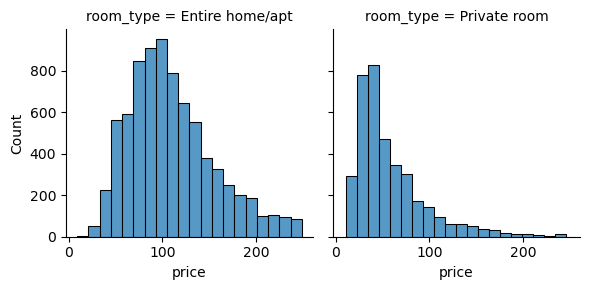

In [12]:
g = sns.FacetGrid(data=airbnb_data[airbnb_data['room_type'].isin(['Entire home/apt', 'Private room'])], col="room_type",col_wrap=2)
g.map(sns.histplot, 'price', bins = 20)
plt.show()

Here we can see a comparison of the price distributions of two room types; private room or entire apartment. As expected, we can observe the price of the private rooms are lower compared to renting an entire home. Also, there is a wider range of prices in the latter. The other two room types were not represented in the histogram due to their small sample size.

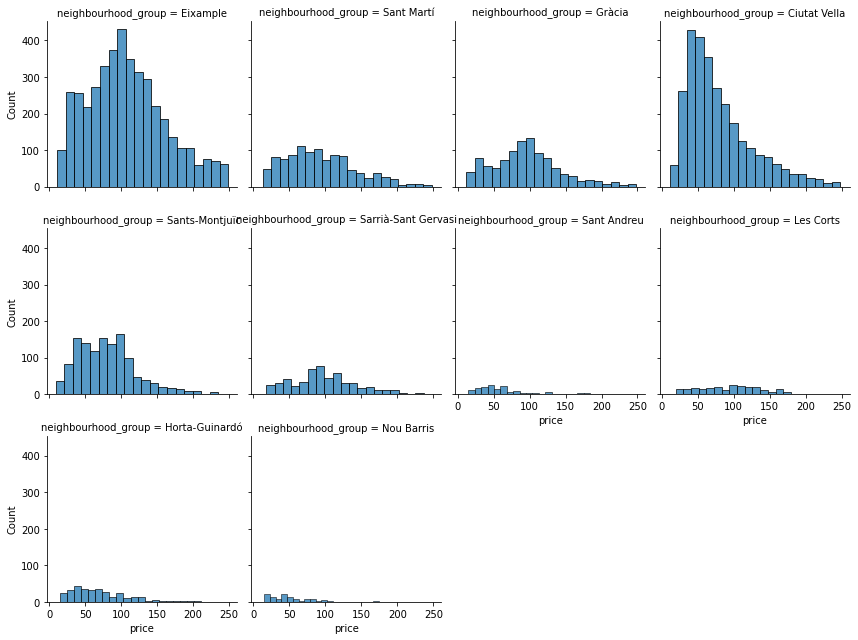

In [49]:
g = sns.FacetGrid(data=airbnb_data, col='neighbourhood_group',col_wrap=4)
g.map(sns.histplot, 'price', bins = 20)

This figure shows the price distributions of the accomodations in each 'districte' (neighbourhood group). There are clear differences in the amount of listings in each 'districte' so, in order to better compare the prices, a bar plot showing the mean price per night of every 'districte' is shown in the next figure

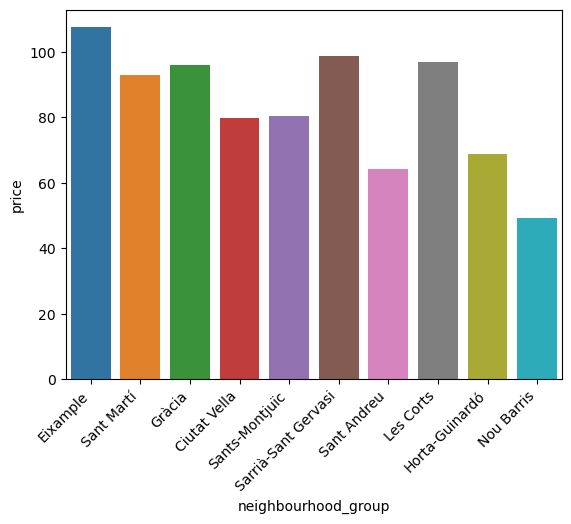

In [13]:
sns.barplot(x=airbnb_data.neighbourhood_group, y=airbnb_data['price'], errorbar=None)
plt.xticks(rotation=45, ha = 'right')
plt.show()

In this bar plot we can see the average of the prices in each neighbourhood group ('districtes'). As in the previous plot, we can also see an expected result, in which the average is the most expensive in the neighbourhood groups closest to the center of the city (Eixample, Sarrià Sant-Gervasi, Les Corts). The most affordable prices are found in the outskirts of the city, for example, in Nou Barris or Sant Andreu. There is a significant difference in prices when comparing the most expensive (Eixample) and the cheapest district (Nou Barris).

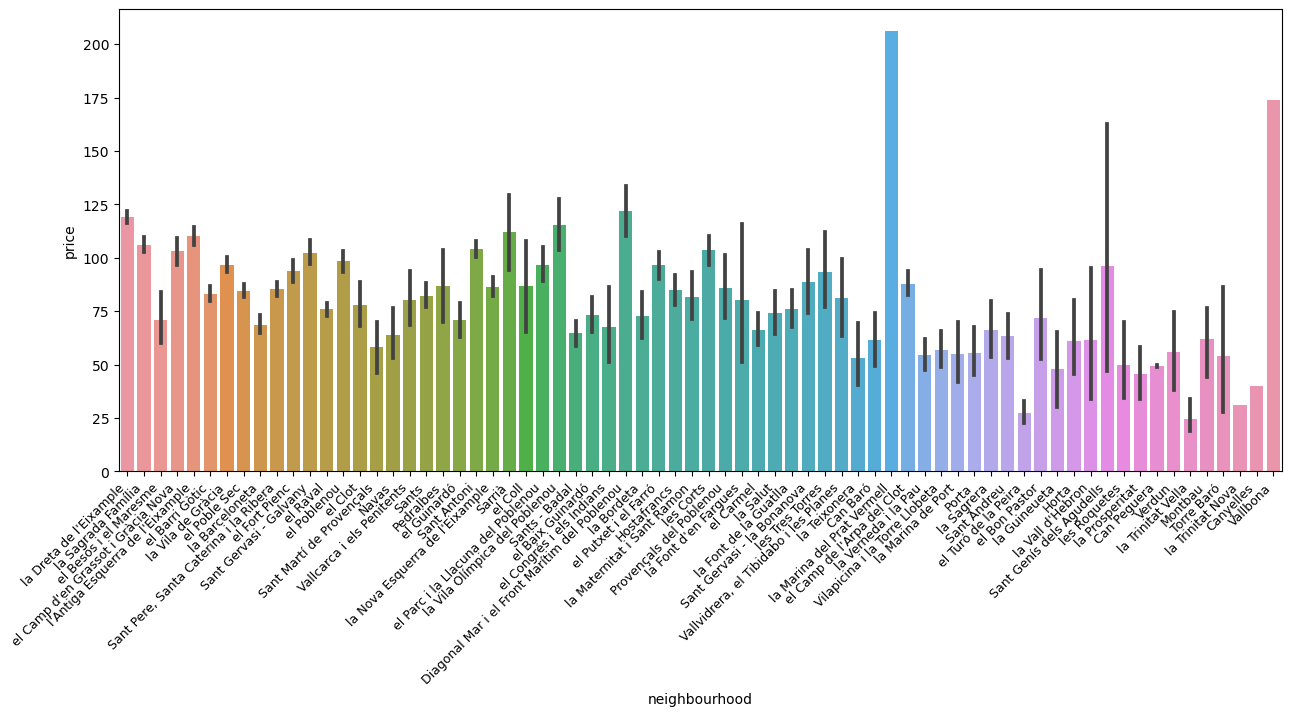

In [14]:
plt.figure(figsize=(15, 6))
sns.barplot(x=airbnb_data.neighbourhood, y=airbnb_data['price'])
plt.xticks(rotation=45, ha = 'right',fontsize=9)
plt.show()

Here we can see the mean price per night of each neighbourhood in euros. The ones without the error bar are most likely a single data point and thus should not be considered reliable for the data.

<Axes: >

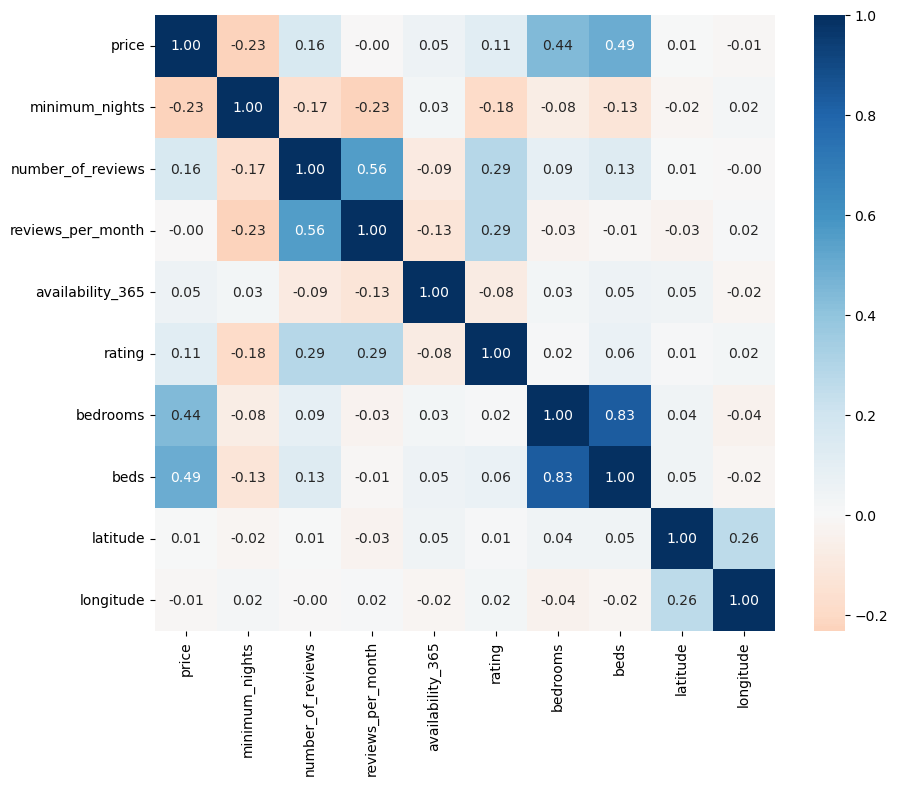

In [16]:
columns_corr = ['price','minimum_nights','number_of_reviews','reviews_per_month',
                'availability_365','rating','bedrooms','beds','latitude','longitude']
correlation_matrix = airbnb_data[columns_corr].corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data=correlation_matrix, cmap='RdBu', annot=True, fmt='.2f',center=0)


This heatmap shows the correlation matrix between some of the numerical variables of this dataset. Blue is representing high correlation whilst reddish colors indicate negative correlation. We can observe a high correlation between the price and the number of beds and bedrooms, as we could expect, and with the number of reviews and rating (meaning, perhaps, that many reviews increase the percieved trust on a specific accomodation). The price is negatively correlated to a higher number of minimum nights. Some other interesting features are the correlation between beds and bedrooms, and they in fact the most correlated features between each other. Another highly correlated feature are the number of total reviews and reviews per month. Other compared features have minimum correlation, close to zero.

In [21]:
import folium
from folium.plugins import HeatMap

# Create a map centered around Barcelona
m = folium.Map(location=[41.3851, 2.1734], zoom_start=12)

# Extract latitude and longitude coordinates and price values
latitudes = airbnb_data['latitude'].tolist()
longitudes = airbnb_data['longitude'].tolist()
prices = airbnb_data['price'].tolist()

# Combine latitude and longitude coordinates into a list of points
heat_data = [[lat, lon, price] for lat, lon, price in zip(latitudes, longitudes, prices)]
HeatMap(heat_data, radius=14, opacity=0.5).add_to(m)
m

In this more visual version of the heatmap, we can clearly see where the most expesive of  accomodations are concentrated. They are, naturally, in the center of the city, close to the beach and in more oppulent areas such as Sarrià-Sant Gervasi and Sants. In more working class places such as Sant Andreu, Nou Barris and also close to Santa COloma de Gramenet and Sant Adrià del Besós, we see significantly lower prices.

## Conclusions ##

In this milestone I learned the usefulness of stacked histograms: I learned how to use stacked histograms to detect if the data preprocessing done so far is appropriate, the use of the "~" sign in conditions to indicate that one condition is opposite to another we have defined, which is useful in data filtering. I also learned to use columns for histograms via booleans: I learned to use columns as booleans in histograms, applying conditions (for example, 'is_NaN') to obtain a list of values and visualize the data clearly once they are stacked. Ultimately, I learned about the power of visualizating data with heatmaps as they offer a very clear picture of correlations and, of course, that I should not underestimate again the amount of time, effort and work data preprocessing actually takes.
